### Code for running experiment
### Callin Switzer
### 21 Feb 2019

In [1]:
from nectarUtils import *

In [2]:
%matplotlib inline
print(sys.version)
print(sys.executable)

3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 11:48:23) [MSC v.1900 64 bit (AMD64)]
C:\Users\Combes4\Anaconda2\envs\NectarLearning\python.exe


In [3]:
# define directories
baseDir = os.getcwd()

# may want to make this directory somewhere else, if dropbox becomes a problem
dataDir = r"D:\Dropbox\AcademiaDropbox\UW\BeeDecisionProject\NectarData"
if not os.path.isdir(dataDir):
    os.mkdir(dataDir)

figDir = r"D:\Dropbox\AcademiaDropbox\UW\BeeDecisionProject\NectarFigs"
if not os.path.isdir(figDir):
    os.mkdir(figDir)

In [4]:
# list serial ports
serial_ports()

['COM8']

In [5]:
# connect to com8
PORT1 = "COM8"
connected1 = False
if "ser1" in globals():
    ser1.close()
ser1 = serial.Serial(PORT1,9600, timeout=1.0) # stop if no data comes in 1 second
while not connected1:
    serin1 = ser1.read()
    connected1 = True
    print("connected to arduino on " + PORT1)
str(ser1.readline().decode("UTF-8"))    

connected to arduino on COM8


' Setup complete\r\n'

keyboard break
8.135018110275269


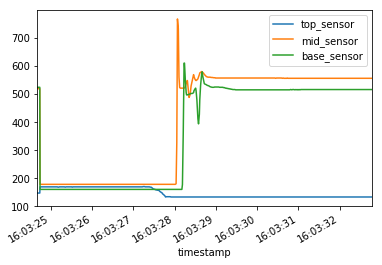

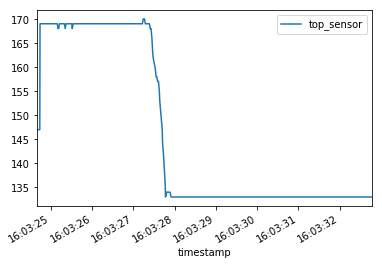

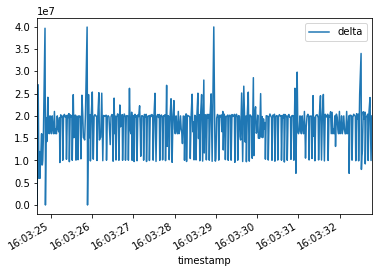

In [64]:
# read and save data
stt = time.time()

newDat = readAndSave(ser1, maxTime=600*2, saveData=True,dataDir = dataDir, timeout = 600*2, PORT = PORT1)

print(time.time() - stt)
newDat.head()

newDat['timestamp'] = pd.to_datetime(newDat['timestamp'])
newDat['delta'] = (newDat['timestamp']-newDat['timestamp'].shift()).fillna(pd.Timedelta(seconds=0))

newDat.plot(y=['top_sensor', 'mid_sensor', 'base_sensor'], x = "timestamp", style='-')

newDat.plot(y=['top_sensor'], x = "timestamp", style='-')

newDat.plot(y=['delta'], x = "timestamp", style='-')

In [65]:
def Reward(serial_con, numSteps =10):
    """
    Moves nectar up the tube, so that it is accessible by the bees.
    
    Only moves nectar if 
        (1) nectar is low
        refref (2) limit switches are open                   
    
    Parameters:
        serial_con (string): arduino serial connection
        
    Returns: 
        None
    """


    if nectarState != "low":
        print('Nectar is not in the correct position')
    else:
        [serial_con.write("f".encode("utf-8")) for ii in range(numSteps)]
        
        # wait one second
        time.sleep(1.0)

        # return nectar to bottom position
        # move at least as far as it went up, and then slowly move forward until the lowest
        # photogate changes
        [serial_con.write("b".encode("utf-8")) for ii in range(numSteps+20)]
        
        # we must wait for the motor to stop moving
        time.sleep(3)
        
        # move back forward until the base sensor is seeing the liquid
        tmp = np.empty((1, 6), dtype = '<U26')
        for ii in range(50):
            
            serial_con.write("r".encode("utf-8"))
            txt = serial_con.readline().decode("utf-8")
            #print(txt)
            tmp[0, 0:5] = [int(i) for i in txt.split(',')]
            print(tmp[0, 2])
            
            # refref: this is not right
            # note: tmp[0,2] is the base sensor for COM8
            if int(tmp[0, 2]) > 200:
                print("BREAKTIME")
                break
                             
            serial_con.write("f".encode("utf-8"))
            time.sleep(0.3)
    

In [66]:
nectarState = "low"
Reward(ser1)

515
BREAKTIME


In [ ]:
numSteps = 4
[ser1.write("f".encode("utf-8")) for ii in range(numSteps)]

In [15]:
ser1.readline().decode("utf-8")

''

In [ ]:
newDat.plot(y=['mid_sensor'], x = "timestamp", style='-')


# for com7
df1[["base_sensor", "mid_sensor", 
     "top_sensor", "limit_1", "limit_2"]] = \
    df1[["base_sensor", "mid_sensor", 
        "top_sensor", "limit_1", "limit_2"]].astype(int)

df1.head()

In [ ]:
# for com8, switch base and mid refref, double check
tt = readData(ser1, readlen=10, wait_time=0.0, save=True, returnVals = True)
df1 = pd.DataFrame(tt, columns=["base_sensor", "mid_sensor", "top_sensor", "limit_1", "limit_2", "timestamp"])

df1[["mid_sensor", "base_sensor",
     "top_sensor", "limit_1", "limit_2"]] = \
    df1[["base_sensor", "mid_sensor", 
        "top_sensor", "limit_1", "limit_2"]].astype(int)

print(df1.shape)
df1.head()

In [ ]:
df1.tail()

In [ ]:
#np.array(df1.iloc[:,0].astype(int))

In [ ]:
ax1 = df1.iloc[:, 0:3].plot()
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')  

In [ ]:
plt.plot(df1[["base_sensor", "mid_sensor", 
     "top_sensor"]])
plt.show()

In [ ]:
plt.plot(np.array(df1.iloc[:,1].astype(int)))

In [ ]:
plt.plot(np.array(df1.iloc[:,2].astype(int)))

In [ ]:
(tt[0, 5])

In [ ]:
# for com7
# top sensor
tt[:, 2]

# mid sensor
tt[:, 1]

# base sensor
tt[:, 0]

In [ ]:
plt.plot(tt[:,2])

In [ ]:
plt.plot(tt)

In [ ]:
#ser1.close()

In [ ]:
def moveToTop(serial_con, cutoff = 650):
    # refref: may want to go 1 or two more moves forward after cutoff is passed --- 
    ## the cutoff is the meniscus
    [[topVal, bottomLim, topLim]] = readData(serial_con, 1, 0)[:, [1,3,4]]
    print(topVal)
    while (topVal > cutoff) and not topLim:
        #move forward
        ser1.write("f".encode("utf-8"))
        
        # read data again
        [[topVal, bottomLim, topLim]] = readData(serial_con, 1, 0)[:,[1,3,4]]
        # rror if limit switch is hit
        if topLim:
            raise RuntimeError('Hit upper limit switch')
        
        
        
        

In [ ]:
# refref: problem -- liquid stays stuck on the sides -- may need to move back slower

def moveBack(serial_con, cutoff = 650):
    
    [[topVal, bottomLim, topLim]] = readData(serial_con, 1, 0)[:, [1,3,4]]
    
    
    while (topVal < cutoff) and not bottomLim:
        #move backward
        for jj in range(7):
            ser1.write("b".encode("utf-8"))
            time.sleep(0.3)
        
        # read data again
        [[topVal, bottomLim, topLim]] = readData(serial_con, 1, 0)[:, [1,3,4]]
        # rror if limit switch is hit
        if bottomLim:
            raise RuntimeError('Hit lower limit switch')

In [ ]:
readData(ser1, 1, 0)

In [ ]:
moveToTop(ser1)
readData(ser1, 1, 0)

In [ ]:
moveBack(ser1)
readData(ser1, 1, 0)

In [ ]:
ser1.write("f".encode("utf-8"))

In [ ]:
[[vals, bottomLim, topLim]] = readData(ser1, 1, 0)[:, 2:]

In [ ]:
readData(ser1, 1, 0)[:, 2:]

In [ ]:
toplim = 1

In [ ]:
not toplim

for ii in range(20): 
    written = ser1.write("f".encode("utf-8"))


ser1.write("f".encode("utf-8"))

for ii in range(100): 
    written = ser1.write("b".encode("utf-8"))

"c".encode("utf-8")
int.from_bytes(b'c', byteorder='big') # this is what the arduino will see

int.from_bytes(b'c', byteorder='big')

ser1.write("c".encode("utf-8"))